In [1]:
# Importing packages

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import seaborn as sns

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Read in the Statcast Data
stat_15 = pd.read_csv('../01_Data/statcast_15.zip', parse_dates=['game_date'])
stat_16 = pd.read_csv('../01_Data/statcast_16.zip', parse_dates=['game_date'])
stat_17 = pd.read_csv('../01_Data/statcast_17.zip', parse_dates=['game_date'])
stat_18 = pd.read_csv('../01_Data/statcast_18.zip', parse_dates=['game_date'])
stat_19 = pd.read_csv('../01_Data/statcast_19.zip', parse_dates=['game_date'])
stat_20 = pd.read_csv('../01_Data/statcast_20.zip', parse_dates=['game_date'])

In [4]:
#Combine the data into a single dataframe
stat_years_combined_list = [stat_15, stat_16, stat_17, stat_18, stat_19, stat_20]
stat_years_combined_df = pd.concat(stat_years_combined_list, ignore_index=True)
stat_years_combined_df

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,0,FF,2015-11-01,96.1,-2.17,6.17,Wade Davis,527038.0,451584.0,...,2.0,7.0,2.0,7.0,7.0,2.0,2.0,7.0,Standard,Strategic
1,1,1,FC,2015-11-01,93.1,-1.82,6.27,Wade Davis,527038.0,451584.0,...,2.0,7.0,2.0,7.0,7.0,2.0,2.0,7.0,Standard,Strategic
2,2,2,FF,2015-11-01,97.0,-1.80,6.25,Wade Davis,527038.0,451584.0,...,2.0,7.0,2.0,7.0,7.0,2.0,2.0,7.0,Standard,Strategic
3,3,3,FC,2015-11-01,93.6,-1.74,6.17,Wade Davis,527038.0,451584.0,...,2.0,7.0,2.0,7.0,7.0,2.0,2.0,7.0,Strategic,Strategic
4,4,4,FF,2015-11-01,97.1,-1.82,6.23,Wade Davis,527038.0,451584.0,...,2.0,7.0,2.0,7.0,7.0,2.0,2.0,7.0,Strategic,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3925773,279655,20155,FF,2020-07-23,96.1,-3.28,5.13,Max Scherzer,543305.0,453286.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infield shift,Standard
3925774,279656,20157,CU,2020-07-23,79.7,-3.36,5.48,Max Scherzer,543305.0,453286.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infield shift,Standard
3925775,279657,20159,FF,2020-07-23,96.7,-3.21,5.33,Max Scherzer,543305.0,453286.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infield shift,Standard
3925776,279658,20162,FF,2020-07-23,96.1,-3.38,5.33,Max Scherzer,543305.0,453286.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Infield shift,Standard


In [5]:
#Split out years
stat_years_combined_df['year'] = stat_years_combined_df['game_date'].apply(lambda x: x.strftime('%Y'))

In [6]:
#Inspect the data
stat_years_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925778 entries, 0 to 3925777
Data columns (total 92 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   Unnamed: 0                       int64         
 1   index                            int64         
 2   pitch_type                       object        
 3   game_date                        datetime64[ns]
 4   release_speed                    float64       
 5   release_pos_x                    float64       
 6   release_pos_z                    float64       
 7   player_name                      object        
 8   batter                           float64       
 9   pitcher                          float64       
 10  events                           object        
 11  description                      object        
 12  spin_dir                         float64       
 13  spin_rate_deprecated             float64       
 14  break_angle_deprecated           f

In [7]:
#Subset for what we need for effective pitching analysis
stat_combined_pitches = stat_years_combined_df[['index', 'year', 'pitch_name', 'game_type', 'launch_speed_angle', 'release_speed', 
                                                'hit_distance_sc', 'type', 'pfx_x', 'pfx_z', 'launch_speed']]

#Create function to recast 2-Seamers as Sinkers
def sinkers(series):
    """Reclassifies Pitches per 2020 Statcast Guidelines"""
    if series == '2-Seam Fastball':
        return 'Sinker'
    elif series == 'Fastball':
        return '4-Seam Fastball'
    else:
        return series

#Apply function to data, subset for regular season games, screen out pitches and balls
stat_combined_pitches['pitch_name'] = stat_combined_pitches['pitch_name'].apply(sinkers)
stat_combined_pitches = stat_combined_pitches[stat_combined_pitches.game_type == 'R']
stat_combined_pitches = stat_combined_pitches[stat_combined_pitches.pitch_name != 'Screwball']
stat_combined_pitches = stat_combined_pitches[stat_combined_pitches.pitch_name != 'Pitch Out']
stat_combined_pitches = stat_combined_pitches[stat_combined_pitches.pitch_name != 'Unknown']
stat_combined_pitches = stat_combined_pitches[stat_combined_pitches.type != 'B']
stat_combined_pitches.type.value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


S    1771866
X     682820
Name: type, dtype: int64

In [8]:
#Aggregate the data columns
rLaunch_ct = stat_combined_pitches.groupby(['pitch_name', 'launch_speed_angle', 'year']).count()
rLaunch_ct = rLaunch_ct['index']
rLaunch_ct = pd.DataFrame(data = rLaunch_ct)
rLaunch_ct = rLaunch_ct.rename(columns = {"index": "pitches"})
rLaunch_ct

pitches
pitch_name      launch_speed_angle year         
4-Seam Fastball 1.0                2015      991
                                   2016      944
                                   2017     1310
                                   2018      814
                                   2019      860
...                                          ...
Split-Finger    6.0                2016       97
                                   2017      117
                                   2018      108
                                   2019       98
                                   2020       48

[370 rows x 1 columns]

In [9]:
#Calculate Total Pitches
totesmcgoats = stat_combined_pitches.groupby(['pitch_name', 'year']).count()
totesmcgoats = totesmcgoats['index']
totesmcgoats = pd.DataFrame(data = totesmcgoats)
totesmcgoats = totesmcgoats.rename(columns = {"index": "pitches"})
totesmcgoats = totesmcgoats.unstack().fillna(0)
totesmcgoats[('pitches','Total')] = totesmcgoats[('pitches','2020')] + totesmcgoats[('pitches','2019')] + totesmcgoats[('pitches','2018')] + totesmcgoats[('pitches','2017')] + totesmcgoats[('pitches','2016')] + totesmcgoats[('pitches','2015')]
totesmcgoats

pitches                                                   \
year                 2015      2016      2017      2018      2019     2020   
pitch_name                                                                   
4-Seam Fastball  163804.0  167937.0  163087.0  165723.0  171864.0  58040.0   
Changeup          46473.0   45318.0   43698.0   46181.0   49532.0  19040.0   
Curveball         31750.0   37055.0   33663.0   33493.0   37634.0  14432.0   
Cutter            25380.0   22763.0   24417.0   26343.0   30215.0  11317.0   
Eephus              175.0      59.0      99.0     134.0      31.0      0.0   
Forkball            116.0     179.0     144.0      47.0      20.0      3.0   
Knuckle Curve      9449.0    9271.0   13132.0   12139.0   10027.0   3570.0   
Knuckleball        2364.0    2598.0    1646.0     469.0      92.0     10.0   
Sinker            96573.0   93447.0   95368.0   90214.0   76118.0  27671.0   
Slider            65626.0   69475.0   72062.0   76481.0   81150.0  29102.0   
Split-Finger       7158.0    6362.0    7205.0    6273.0    6428.0   2749.0   

                           
year                Total  
pitch_name                 
4-Seam Fastball  890455.0  
Changeup         250242.0  
Curveball        188027.0  
Cutter           140435.0  
Eephus              498.0  
Forkball            509.0  
Knuckle Curve     57588.0  
Knuckleball        7179.0  
Sinker           479391.0  
Slider           393896.0  
Split-Finger      36175.0

In [10]:
#Calculate Total Barrels
bcounts = rLaunch_ct.loc[(slice(None), 6.0),:]
bcounts = bcounts.unstack()
bcounts = bcounts.reset_index(level = 1, drop = True)
bcounts = bcounts.fillna(0)
bcounts[('pitches','Total')] = bcounts[('pitches','2020')] + bcounts[('pitches','2019')] + bcounts[('pitches','2018')] + bcounts[('pitches','2017')] + bcounts[('pitches','2016')] + bcounts[('pitches','2015')]
bcounts

pitches                                                 
year               2015    2016    2017    2018    2019    2020    Total
pitch_name                                                              
4-Seam Fastball  2881.0  3233.0  3149.0  3607.0  3936.0  1413.0  18219.0
Changeup          682.0   746.0   768.0   769.0   873.0   352.0   4190.0
Curveball         326.0   453.0   417.0   441.0   550.0   204.0   2391.0
Cutter            406.0   371.0   401.0   470.0   568.0   241.0   2457.0
Eephus              3.0     0.0     2.0     0.0     0.0     0.0      5.0
Forkball            1.0     3.0     1.0     3.0     1.0     0.0      9.0
Knuckle Curve      82.0   100.0   143.0   175.0   163.0    58.0    721.0
Knuckleball        38.0    41.0    29.0     9.0     2.0     1.0    120.0
Sinker           1527.0  1769.0  1781.0  1764.0  1615.0   558.0   9014.0
Slider            799.0  1060.0  1058.0  1083.0  1420.0   476.0   5896.0
Split-Finger       95.0    97.0   117.0   108.0    98.0    48.0    563.0

In [11]:
#Calculate barrel percentages
bbpcts = (bcounts/totesmcgoats)*100
bbpcts = bbpcts.sort_values(by=[('pitches','Total')], ascending = False)
bbpcts = bbpcts.round(3).fillna(0)
bbpcts

pitches                                           
year               2015   2016   2017   2018   2019    2020  Total
pitch_name                                                        
4-Seam Fastball   1.759  1.925  1.931  2.177  2.290   2.435  2.046
Sinker            1.581  1.893  1.868  1.955  2.122   2.017  1.880
Forkball          0.862  1.676  0.694  6.383  5.000   0.000  1.768
Cutter            1.600  1.630  1.642  1.784  1.880   2.130  1.750
Changeup          1.468  1.646  1.758  1.665  1.762   1.849  1.674
Knuckleball       1.607  1.578  1.762  1.919  2.174  10.000  1.672
Split-Finger      1.327  1.525  1.624  1.722  1.525   1.746  1.556
Slider            1.218  1.526  1.468  1.416  1.750   1.636  1.497
Curveball         1.027  1.223  1.239  1.317  1.461   1.414  1.272
Knuckle Curve     0.868  1.079  1.089  1.442  1.626   1.625  1.252
Eephus            1.714  0.000  2.020  0.000  0.000   0.000  1.004

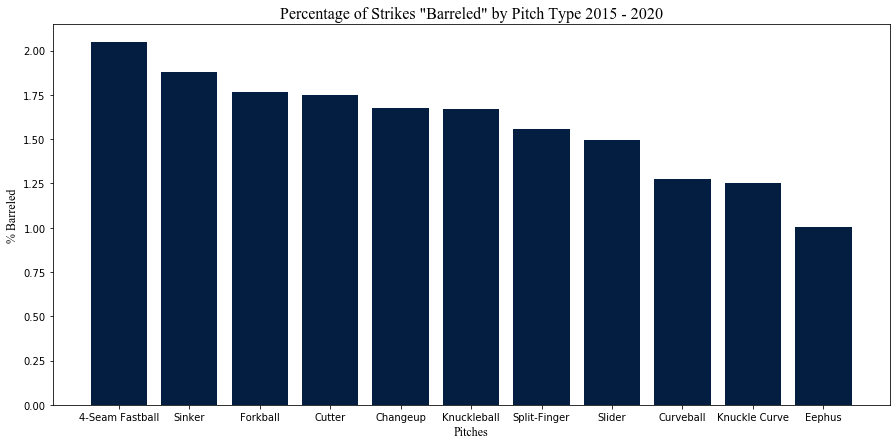

In [12]:
#Plot total barrel percentage data
fig1 = plt.figure(figsize = (15,7))
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('Percentage of Strikes "Barreled" by Pitch Type 2015 - 2020', fontname = "Times New Roman", fontsize = 16)
ax1.set_xlabel('Pitches', fontname = "Times New Roman", fontsize = 12)
ax1.set_ylabel('% Barreled', fontname = "Times New Roman", fontsize = 12)

pitches = bbpcts.index
percents = bbpcts[('pitches', 'Total')].values
plt.bar(pitches, percents, color = '#041E42')
pass

#Print the Graph
plt.savefig('Barrel2.png', dpi = 400)

In [13]:
#Plot Trends without totals
bbtrends = bbpcts.drop(('pitches', 'Total'), axis = 1)
bbtrends

pitches                                    
year               2015   2016   2017   2018   2019    2020
pitch_name                                                 
4-Seam Fastball   1.759  1.925  1.931  2.177  2.290   2.435
Sinker            1.581  1.893  1.868  1.955  2.122   2.017
Forkball          0.862  1.676  0.694  6.383  5.000   0.000
Cutter            1.600  1.630  1.642  1.784  1.880   2.130
Changeup          1.468  1.646  1.758  1.665  1.762   1.849
Knuckleball       1.607  1.578  1.762  1.919  2.174  10.000
Split-Finger      1.327  1.525  1.624  1.722  1.525   1.746
Slider            1.218  1.526  1.468  1.416  1.750   1.636
Curveball         1.027  1.223  1.239  1.317  1.461   1.414
Knuckle Curve     0.868  1.079  1.089  1.442  1.626   1.625
Eephus            1.714  0.000  2.020  0.000  0.000   0.000

In [14]:
#Calculate pitch mix percentages
pitch_mix = stat_combined_pitches.groupby(['pitch_name', 'year']).count()
pitch_mix = pitch_mix['index']
pitch_mix = pd.DataFrame(data = pitch_mix)
pitch_mix = pitch_mix.rename(columns = {"index": "pitches"})
pitch_mix = pitch_mix.unstack().fillna(0)
pitch_mix_pcts = pitch_mix.apply(lambda x: 100 * (x / x.sum()))
pitch_mix_pcts = pitch_mix_pcts.sort_values(('pitches', '2020'), ascending = False).round(3)
pitch_mix_pcts = pitch_mix_pcts.T
pitch_mix_pcts.columns = ['Four_Seam_Fastball', 'Slider', 'Sinker', 'Changeup', 'Curveball', 'Cutter', 'Knuckle_Curve',
                          'Split_Finger', 'Knuckleball', 'Forkball', 'Eephus']
pitch_mix_pcts = pitch_mix_pcts.reset_index(level = 0, drop = True)
pitch_mix_pcts

,Four_Seam_Fastball,Slider,Sinker,Changeup,Curveball,Cutter,Knuckle_Curve,Split_Finger,Knuckleball,Forkball,Eephus
year,,,,,,,,,,,
2015,36.493,14.620,21.515,10.353,7.073,5.654,2.105,1.595,0.527,0.026,0.039
2016,36.953,15.287,20.562,9.972,8.154,5.009,2.040,1.400,0.572,0.039,0.013
2017,35.881,15.854,20.982,9.614,7.406,5.372,2.889,1.585,0.362,0.032,0.022
2018,36.224,16.717,19.719,10.094,7.321,5.758,2.653,1.371,0.103,0.010,0.029
2019,37.111,17.523,16.436,10.695,8.126,6.524,2.165,1.388,0.020,0.004,0.007
2020,34.978,17.538,16.676,11.474,8.697,6.820,2.151,1.657,0.006,0.002,0.000


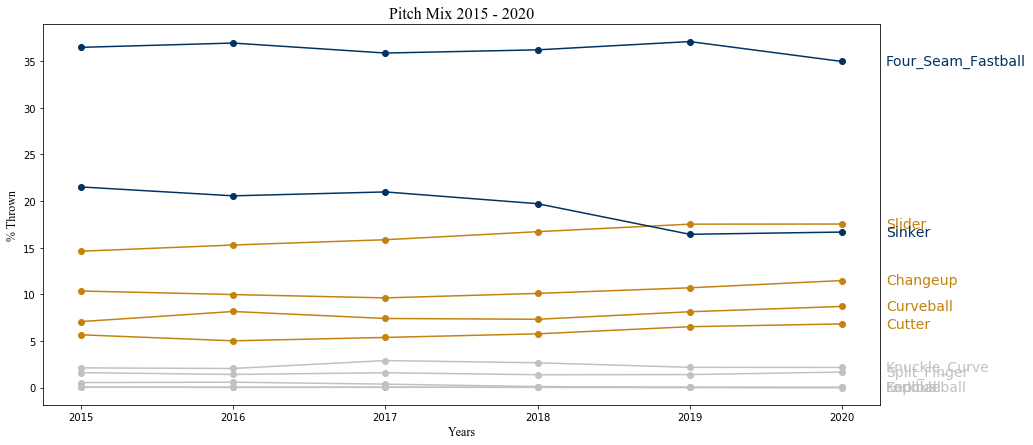

In [15]:
#Vizualize Pitchmix Data
fig3 = plt.figure(figsize = (15,7))
ax3 = fig3.add_subplot(1,1,1)
ax3.set_title('Pitch Mix 2015 - 2020', fontname = "Times New Roman", fontsize = 16)
ax3.set_xlabel('Years', fontname = "Times New Roman", fontsize = 12)
ax3.set_ylabel('% Thrown', fontname = "Times New Roman", fontsize = 12)


plt.plot(pitch_mix_pcts.Four_Seam_Fastball, color = "#003262", marker = "o", label = "4-Seam Fastball")
plt.plot(pitch_mix_pcts.Slider, color = "#C4820F", marker = "o", label = "Slider")
plt.plot(pitch_mix_pcts.Sinker, color = "#003262", marker = "o", label = "Sinker")
plt.plot(pitch_mix_pcts.Changeup, color = "#C4820F", marker = "o", label = "Changeup")
plt.plot(pitch_mix_pcts.Curveball, color = "#C4820F", marker = "o", label = "Curveball")
plt.plot(pitch_mix_pcts.Cutter, color = "#C4820F", marker = "o", label = "Cutter")
plt.plot(pitch_mix_pcts.Knuckle_Curve, color = "#C1C1C1", marker = "o")
plt.plot(pitch_mix_pcts.Split_Finger, color = "#C1C1C1", marker = "o")
plt.plot(pitch_mix_pcts.Knuckleball, color = "#C1C1C1", marker = "o")
plt.plot(pitch_mix_pcts.Forkball, color = "#C1C1C1", marker = "o")
plt.plot(pitch_mix_pcts.Eephus, color = "#C1C1C1", marker = "o")

for line, name in zip(ax3.lines, pitch_mix_pcts.columns):
    y = line.get_ydata()[-1]
    ax3.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax3.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")

#Print the Graph
plt.savefig('Pitch Mix.png', dpi = 1000)
pass

In [16]:
#Calculate pitch speed data
pitch_speeds = stat_combined_pitches.groupby(['pitch_name', 'year']).agg({'release_speed': 'mean'})
pitch_speeds = pd.DataFrame(data = pitch_speeds)
pitch_speeds = pitch_speeds.unstack().fillna(0)
pitch_speeds = pitch_speeds.sort_values(('release_speed', '2020'), ascending = False).round(1)
pitch_speeds

release_speed                              
year                     2015  2016  2017  2018  2019  2020
pitch_name                                                 
4-Seam Fastball          93.2  93.2  93.3  93.2  93.4  93.4
Sinker                   92.1  92.4  92.2  92.2  92.5  92.7
Cutter                   88.5  88.7  88.5  88.6  88.4  88.2
Forkball                 87.2  85.9  87.1  86.3  81.3  87.9
Split-Finger             85.0  84.9  84.6  85.2  85.2  85.2
Changeup                 83.9  84.1  84.1  84.1  84.4  84.4
Slider                   84.8  84.9  84.5  84.4  84.6  84.4
Knuckle Curve            80.8  80.9  80.5  80.8  80.8  81.4
Curveball                78.3  78.2  77.9  78.3  78.4  78.4
Knuckleball              76.5  75.7  76.9  75.9  73.9  59.9
Eephus                   67.7  66.6  67.3  67.8  65.3   0.0

In [17]:
#Inspect fastball data
fastballs = stat_combined_pitches[(stat_combined_pitches['pitch_name'] == "4-Seam Fastball")]
fastballs[(fastballs['release_speed'] <= 90)].describe()

,index,launch_speed_angle,release_speed,hit_distance_sc,pfx_x,pfx_z,launch_speed
count,98380.000000,25844.000000,98380.000000,37977.000000,98380.000000,98380.000000,27172.000000
mean,11947.961273,3.391735,88.357137,190.345314,-0.132510,1.388024,89.433211
std,6920.123213,1.246782,2.068616,119.957005,0.717012,0.396714,12.907928
min,0.000000,1.000000,53.000000,0.000000,-2.300000,-1.500000,17.600000
25%,6019.000000,2.000000,87.800000,94.000000,-0.700000,1.200000,80.600000
50%,11716.000000,3.000000,88.900000,191.000000,-0.300000,1.400000,91.200000
75%,17819.000000,4.000000,89.600000,286.000000,0.500000,1.600000,99.400000
max,26921.000000,6.000000,90.000000,489.000000,2.200000,2.900000,119.700000


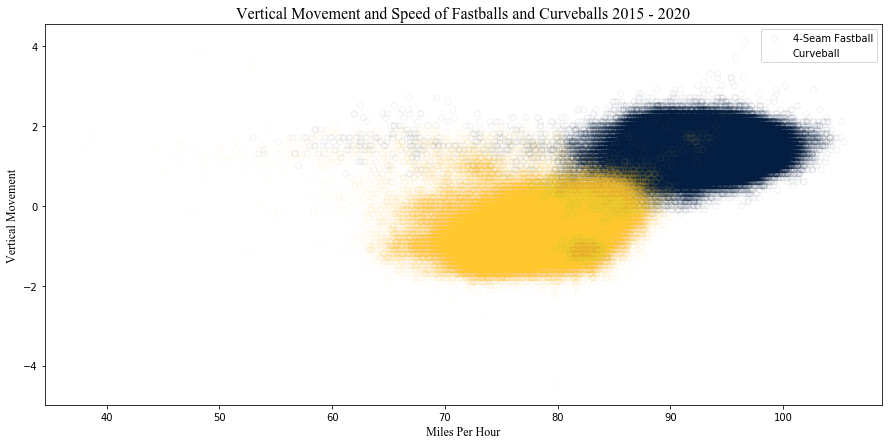

In [42]:
#Calculate speed and movement for Fastballs and Curveballs
movement = stat_combined_pitches[['pitch_name', 'release_speed', 'pfx_x', 'pfx_z']]
ffmovement = movement[(movement['pitch_name'] == '4-Seam Fastball')]
cvmovement = movement[(movement['pitch_name'] == 'Curveball')]

#Plot movement and speed
fig2 = plt.figure(figsize = (15,7))
ax2 = fig2.add_subplot(1,1,1)
ax2.set_title('Vertical Movement and Speed of Fastballs and Curveballs 2015 - 2020', fontname = "Times New Roman", fontsize = 16)
ax2.set_xlabel('Miles Per Hour', fontname = "Times New Roman", fontsize = 12)
ax2.set_ylabel('Vertical Movement', fontname = "Times New Roman", fontsize = 12)

move1 = ffmovement['pfx_z']
speed1 = ffmovement['release_speed']
move2 = cvmovement['pfx_z']
speed2 = cvmovement['release_speed']

ax2.scatter(speed1, move1, edgecolors = '#041E42', alpha = 0.05, color = "None", label = "4-Seam Fastball")
ax2.scatter(speed2, move2, edgecolors = '#FFC72C', alpha = 0.05, color = "None", label = "Curveball")
ax2.legend()

#plt.show()

#Print the Graph
plt.savefig('Pitch_Movement.png')

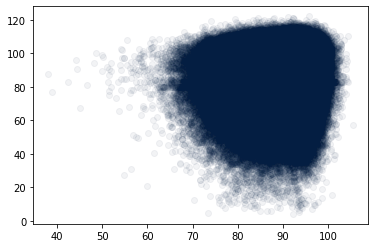

In [29]:
#Inspect relationship between launch speed and release speed
launches = stat_combined_pitches[['launch_speed', 'release_speed']]
pitch_speed = launches['release_speed']
exit_velo = launches['launch_speed']

plt.scatter(pitch_speed, exit_velo, alpha = 0.05, c = '#041E42')



In [30]:
#Find overall barrels by year
overallb = stat_combined_pitches.groupby(['launch_speed_angle', 'year']).count()
overallb = overallb['index']
overallb = pd.DataFrame(data = overallb)
overallb = overallb.rename(columns = {"index": "pitches"})
overallb = overallb.unstack()
overallb.loc['Total'] = overallb.sum()
overallb

pitches                                       
year                  2015    2016    2017    2018    2019   2020
launch_speed_angle                                               
1.0                   3587    3435    5755    3447    3502   1933
2.0                  46218   44299   41365   42180   41164  13952
3.0                  30086   30676   31191   31471   31350  11156
4.0                  32027   31729   31582   30968   30851  10631
5.0                   6753    6937    7042    7470    7424   2645
6.0                   6845    7886    7872    8435    9248   3351
Total               125516  124962  124807  123971  123539  43668

In [31]:
#Calculate overall strikes data
tmg2 = totesmcgoats
tmg2.loc['Total'] = tmg2.sum()
tmg2

pitches                                                    \
year                 2015      2016      2017      2018      2019      2020   
pitch_name                                                                    
4-Seam Fastball  163804.0  167937.0  163087.0  165723.0  171864.0   58040.0   
Changeup          46473.0   45318.0   43698.0   46181.0   49532.0   19040.0   
Curveball         31750.0   37055.0   33663.0   33493.0   37634.0   14432.0   
Cutter            25380.0   22763.0   24417.0   26343.0   30215.0   11317.0   
Eephus              175.0      59.0      99.0     134.0      31.0       0.0   
Forkball            116.0     179.0     144.0      47.0      20.0       3.0   
Knuckle Curve      9449.0    9271.0   13132.0   12139.0   10027.0    3570.0   
Knuckleball        2364.0    2598.0    1646.0     469.0      92.0      10.0   
Sinker            96573.0   93447.0   95368.0   90214.0   76118.0   27671.0   
Slider            65626.0   69475.0   72062.0   76481.0   81150.0   29102.0   
Split-Finger       7158.0    6362.0    7205.0    6273.0    6428.0    2749.0   
Total            448868.0  454464.0  454521.0  457497.0  463111.0  165934.0   

                            
year                 Total  
pitch_name                  
4-Seam Fastball   890455.0  
Changeup          250242.0  
Curveball         188027.0  
Cutter            140435.0  
Eephus               498.0  
Forkball             509.0  
Knuckle Curve      57588.0  
Knuckleball         7179.0  
Sinker            479391.0  
Slider            393896.0  
Split-Finger       36175.0  
Total            2444395.0

In [32]:
#Calculate overall barrel percentages by year
overallb.loc[6.0] / tmg2.loc['Total']

         year 
pitches  2015     0.015249
         2016     0.017352
         2017     0.017319
         2018     0.018437
         2019     0.019969
         2020     0.020195
         Total         NaN
dtype: float64

In [33]:
#Calculate overall pitch speed data
pitch_speeds = stat_combined_pitches.groupby(['pitch_name']).agg({'release_speed': 'mean'}).sort_values(by = 'release_speed', ascending = False)
pitch_speeds


,release_speed
pitch_name,
4-Seam Fastball,93.264425
Sinker,92.285371
Cutter,88.508023
Forkball,86.392534
Split-Finger,84.978167
Slider,84.630331
Changeup,84.144043
Knuckle Curve,80.795518
Curveball,78.231406
